In [1]:
import polars as pl
from itertools import combinations
from collections import Counter, defaultdict
import networkx as nx
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from community import community_louvain
import seaborn as sns
from nltk import PorterStemmer, bigrams as nltk_bigrams
from nltk.tokenize import MWETokenizer
import nltk
from scipy.stats import chi2
from nltk.corpus import stopwords
from functools import lru_cache
from wordcloud import WordCloud

sns.set_style("darkgrid")
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Rune\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Final project - Computational Social Science (02476)

> Data is available [here](https://amazon-reviews-2023.github.io/)

## 1. Motivation

## 2. Statistics

## 3. Analysis

## 4. Discussion

### Constants and function definitions

In [2]:
REVIEW_DATA_FILE = 'dataset/Movies_and_TV.jsonl'
META_DATA_FILE = "dataset/meta_Movies_and_TV.jsonl"
EXTENDED_META_DATA_FILE = "dataset/meta_Movies_and_TV_extended.jsonl"

## 1. Data processing

### Process meta data

In [3]:
schema = {
    "title": pl.Utf8,
    "average_rating": pl.Float64,
    "rating_number": pl.Int64,
    "description": pl.List(pl.Utf8),
    "price": pl.Utf8,
    "categories": pl.List(pl.Utf8),
    "details": pl.Struct([
        pl.Field("Content advisory", pl.List(pl.Utf8)),
    ]),
    "parent_asin": pl.Utf8,
}

df_meta_1 = pl.read_ndjson(META_DATA_FILE, schema=schema).rename({"parent_asin": "asin"})
df_meta_2 = pl.read_ndjson(EXTENDED_META_DATA_FILE, schema=schema).rename({"parent_asin": "asin"})

df_meta = pl.concat([df_meta_1, df_meta_2])

# Map prices
df_meta = df_meta.with_columns(
    pl.col("price")
    .str.extract(r"([0-9]+(?:\.[0-9]+)?)", 1)
    .cast(pl.Float64)
    .fill_null(-1)
)

# Map title
df_meta = df_meta.with_columns(
    pl.col("title")
        .str.replace(r"\[.*?\]", "", literal=False)
        .str.replace(r"\(.*?\)", "", literal=False)
        .str.replace(r":\s*Season\s*\d+", "", literal=False) # Group all seasons
        .str.strip_chars()
        .alias("title")
)

# Map description
df_meta = df_meta.with_columns(
    pl.when(
        pl.col("description").is_null() |
        (pl.col("description").list.eval(pl.element()).list.len() == 0)
    )
    .then(pl.lit([""]).cast(pl.List(pl.Utf8)))
    .otherwise(pl.col("description"))
    .alias("description")
)

df_meta = df_meta.with_columns(
    pl.col("description").list.get(0).alias("description") # TODO GET THE LONGEST DESCRIPTION
)

df_meta = df_meta.with_columns(
    pl.col("description").str.len_chars().alias("desc_len")
)

# Map Content advisory
df_meta = df_meta.with_columns(
    pl.struct(["details"]).map_elements(
        lambda s: s["details"]["Content advisory"] if s["details"] and "Content advisory" in s["details"] else [],
        return_dtype=pl.List(pl.Utf8)
    ).alias("details")
).rename({"details": "content_advisory"})

print(df_meta.height)

df_meta.limit(5)

748236


shape: (5, 9)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ title     ┆ average_r ┆ rating_nu ┆ descripti ┆ … ┆ categorie ┆ content_a ┆ asin      ┆ desc_len │
│ ---       ┆ ating     ┆ mber      ┆ on        ┆   ┆ s         ┆ dvisory   ┆ ---       ┆ ---      │
│ str       ┆ ---       ┆ ---       ┆ ---       ┆   ┆ ---       ┆ ---       ┆ str       ┆ u32      │
│           ┆ f64       ┆ i64       ┆ str       ┆   ┆ list[str] ┆ list[str] ┆           ┆          │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ Glee      ┆ 4.7       ┆ 2004      ┆ Entering  ┆ … ┆ ["Comedy" ┆ ["Violenc ┆ B00ABWKL3 ┆ 396      │
│           ┆           ┆           ┆ its       ┆   ┆ ,         ┆ e", "subs ┆ I         ┆          │
│           ┆           ┆           ┆ fourth    ┆   ┆ "Drama",  ┆ tance     ┆           ┆          │
│           ┆           ┆           ┆ season,   ┆   ┆ … "Music  ┆ use", …   ┆           ┆          │
│           ┆           ┆           ┆ th…       ┆   ┆ V…        ┆           ┆           ┆          │
│ One       ┆ 3.0       ┆ 6         ┆ With her  ┆ … ┆ ["Comedy" ┆ []        ┆ B09WDLJ4H ┆ 219      │
│ Perfect   ┆           ┆           ┆ book tour ┆   ┆ ,         ┆           ┆ P         ┆          │
│ Wedding   ┆           ┆           ┆ in two    ┆   ┆ "Drama",  ┆           ┆           ┆          │
│           ┆           ┆           ┆ week…     ┆   ┆ "Romance" ┆           ┆           ┆          │
│           ┆           ┆           ┆           ┆   ┆ ]         ┆           ┆           ┆          │
│ How to    ┆ 5.0       ┆ 7         ┆ Product   ┆ … ┆ ["Movies  ┆ []        ┆ B00AHN851 ┆ 19       │
│ Make Anim ┆           ┆           ┆ Descripti ┆   ┆ & TV",    ┆           ┆ G         ┆          │
│ atronic   ┆           ┆           ┆ on        ┆   ┆ "Genre    ┆           ┆           ┆          │
│ Charac…   ┆           ┆           ┆           ┆   ┆ for Fea…  ┆           ┆           ┆          │
│ Ode to    ┆ 4.3       ┆ 35        ┆ This      ┆ … ┆ ["Documen ┆ []        ┆ B01G9ILXX ┆ 234      │
│ Joy: Beet ┆           ┆           ┆ special   ┆   ┆ tary"]    ┆           ┆ E         ┆          │
│ hoven's   ┆           ┆           ┆ Ode to    ┆   ┆           ┆           ┆           ┆          │
│ Sympho…   ┆           ┆           ┆ Joy:      ┆   ┆           ┆           ┆           ┆          │
│           ┆           ┆           ┆ Beeth…    ┆   ┆           ┆           ┆           ┆          │
│ Ben 10:   ┆ 4.7       ┆ 360       ┆ Itâ€™s    ┆ … ┆ ["Science ┆ []        ┆ B009SIYXD ┆ 377      │
│ Alien     ┆           ┆           ┆ hero time ┆   ┆ Fiction", ┆           ┆ A         ┆          │
│ Force     ┆           ┆           ┆ again for ┆   ┆ "Comedy", ┆           ┆           ┆          │
│           ┆           ┆           ┆ Ben…      ┆   ┆ …         ┆           ┆           ┆          │
└───────────┴───────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴──────────┘

In [4]:
best_per_title = (
    df_meta.sort(["desc_len", "rating_number"], descending=[True, True])
    .group_by("title")
    .agg([
        pl.col("asin").unique().alias("asins"),
        pl.first("asin").alias("asin"), 
        pl.first("average_rating"),
        pl.first("rating_number"),
        pl.first("description"),
        pl.first("price"),
        pl.first("categories"),
        pl.first("content_advisory")
    ])
    .with_columns(
        pl.col("asins").list.len().alias("num_asins")
    )
)
print(best_per_title.height)
best_per_title.sort("num_asins", descending=True).limit(5)

324786


shape: (5, 10)
┌────────────┬────────────┬────────────┬───────────┬───┬───────┬───────────┬───────────┬───────────┐
│ title      ┆ asins      ┆ asin       ┆ average_r ┆ … ┆ price ┆ categorie ┆ content_a ┆ num_asins │
│ ---        ┆ ---        ┆ ---        ┆ ating     ┆   ┆ ---   ┆ s         ┆ dvisory   ┆ ---       │
│ str        ┆ list[str]  ┆ str        ┆ ---       ┆   ┆ f64   ┆ ---       ┆ ---       ┆ u32       │
│            ┆            ┆            ┆ f64       ┆   ┆       ┆ list[str] ┆ list[str] ┆           │
╞════════════╪════════════╪════════════╪═══════════╪═══╪═══════╪═══════════╪═══════════╪═══════════╡
│ null       ┆ ["B08B83GC ┆ B072JHHC7Z ┆ null      ┆ … ┆ -1.0  ┆ null      ┆ ["Foul    ┆ 313988    │
│            ┆ TH", "B00K ┆            ┆           ┆   ┆       ┆           ┆ language" ┆           │
│            ┆ QFX5M4",   ┆            ┆           ┆   ┆       ┆           ┆ , "sexual ┆           │
│            ┆ ……         ┆            ┆           ┆   ┆       ┆           ┆ cont…     ┆           │
│ Charlie    ┆ ["B000HBL5 ┆ B000IU34D2 ┆ 5.0       ┆ … ┆ -1.0  ┆ ["Movies  ┆ []        ┆ 65        │
│ Rose       ┆ 8I", "B000 ┆            ┆           ┆   ┆       ┆ & TV",    ┆           ┆           │
│            ┆ HBL5AG",   ┆            ┆           ┆   ┆       ┆ "Charlie  ┆           ┆           │
│            ┆ ……         ┆            ┆           ┆   ┆       ┆ Rose …    ┆           ┆           │
│ The        ┆ ["B007E6Z9 ┆ B005LAJ22Q ┆ 4.8       ┆ … ┆ 18.98 ┆ ["Movies  ┆ []        ┆ 57        │
│ Walking    ┆ 4U", "B01M ┆            ┆           ┆   ┆       ┆ & TV",    ┆           ┆           │
│ Dead       ┆ XUKXG3",   ┆            ┆           ┆   ┆       ┆ "Boxed    ┆           ┆           │
│            ┆ ……         ┆            ┆           ┆   ┆       ┆ Sets", …  ┆           ┆           │
│ The        ┆ ["B00OBDKT ┆ B003LCIDWG ┆ 4.7       ┆ … ┆ 48.97 ┆ ["Movies  ┆ []        ┆ 55        │
│ Simpsons   ┆ X0", "B000 ┆            ┆           ┆   ┆       ┆ & TV",    ┆           ┆           │
│            ┆ 61I4E2",   ┆            ┆           ┆   ┆       ┆ "Studio   ┆           ┆           │
│            ┆ ……         ┆            ┆           ┆   ┆       ┆ Specia…   ┆           ┆           │
│ A          ┆ ["B00020J0 ┆ B008UY8FI2 ┆ 4.8       ┆ … ┆ 9.99  ┆ ["Movies  ┆ []        ┆ 54        │
│ Christmas  ┆ EK", "B003 ┆            ┆           ┆   ┆       ┆ & TV",    ┆           ┆           │
│ Carol      ┆ VS0CY2",   ┆            ┆           ┆   ┆       ┆ "Featured ┆           ┆           │
│            ┆ ……         ┆            ┆           ┆   ┆       ┆ Cate…     ┆           ┆           │
└────────────┴────────────┴────────────┴───────────┴───┴───────┴───────────┴───────────┴───────────┘

### Process review data

In [5]:
df = pl.scan_ndjson(REVIEW_DATA_FILE).filter(pl.col('verified_purchase') == True).filter(pl.col('helpful_vote') != 0)
existing = set(df.collect_schema().keys())
drop_cols = {'images', 'style', 'verified_purchase', 'asin', 'helpful_vote', 'title'} 
keep_cols = list(existing - drop_cols)
df = df.select(keep_cols).rename({'parent_asin': 'asin'})
df = df.collect()
df.limit(5)

shape: (5, 5)
┌────────────┬──────────────────────────────┬─────────────────────────────┬───────────────┬────────┐
│ asin       ┆ user_id                      ┆ text                        ┆ timestamp     ┆ rating │
│ ---        ┆ ---                          ┆ ---                         ┆ ---           ┆ ---    │
│ str        ┆ str                          ┆ str                         ┆ i64           ┆ f64    │
╞════════════╪══════════════════════════════╪═════════════════════════════╪═══════════════╪════════╡
│ B0002J58ME ┆ AGXVBIUFLFGMVLATYXHJYL4A5Q7Q ┆ This DVD was GREAT!  I am a ┆ 1146713492000 ┆ 5.0    │
│            ┆                              ┆ st…                         ┆               ┆        │
│ B000PIU2A0 ┆ AEFKF6R2GUSK2AWPSWRR4ZO36JVQ ┆ this item was canceled. . . ┆ 1556496429981 ┆ 3.0    │
│            ┆                              ┆ .n…                         ┆               ┆        │
│ B001JNNDRY ┆ AEFKF6R2GUSK2AWPSWRR4ZO36JVQ ┆ I grew up with this one.    ┆ 1364088518000 ┆ 5.0    │
│            ┆                              ┆ could…                      ┆               ┆        │
│ B000TSMOEI ┆ AEFKF6R2GUSK2AWPSWRR4ZO36JVQ ┆ like watching: haven't      ┆ 1364088147000 ┆ 4.0    │
│            ┆                              ┆ gotten …                    ┆               ┆        │
│ B0009MAO82 ┆ AEFKF6R2GUSK2AWPSWRR4ZO36JVQ ┆ pretty cool to watch:       ┆ 1364087577000 ┆ 4.0    │
│            ┆                              ┆ differen…                   ┆               ┆        │
└────────────┴──────────────────────────────┴─────────────────────────────┴───────────────┴────────┘

In [6]:
df.height, df.get_column("asin").n_unique()

(2888210, 409673)

In [7]:
asin_title_map = (
    best_per_title.select([
        pl.col("title"),
        pl.col("asins"),
        pl.col("average_rating"),
        pl.col("price")
    ]).explode("asins")
    .rename({"asins": "asin"})
    .sort("title", nulls_last=True)
    .unique(subset=["asin"], keep="first")
)

df_reviews = df.join(
    asin_title_map,
    on="asin",
    how="left"
)

> All the asin with missing meta data sorted by number of reviews

In [8]:
counts = (
    df_reviews
    .filter(pl.col("title").is_null())
    .group_by("asin")
    .agg(pl.len().alias("null_title_review_count"))
    .sort("null_title_review_count", descending=True)
)
counts.limit(10)

shape: (10, 2)
┌────────────┬─────────────────────────┐
│ asin       ┆ null_title_review_count │
│ ---        ┆ ---                     │
│ str        ┆ u32                     │
╞════════════╪═════════════════════════╡
│ B097YYZ87F ┆ 3406                    │
│ B00I3MOU4Y ┆ 3133                    │
│ B08QZN6LCM ┆ 3123                    │
│ B01J776HVW ┆ 2603                    │
│ B017AOY4WS ┆ 2183                    │
│ B08VF7CR17 ┆ 1874                    │
│ B08LMJ93LL ┆ 1767                    │
│ B00LPRKH5U ┆ 1498                    │
│ B00RSGJ0DW ┆ 1453                    │
│ B00TPJG4QG ┆ 1396                    │
└────────────┴─────────────────────────┘

In [9]:
filtered_df = df_reviews.filter(pl.col("title").is_not_null())
print(filtered_df.height)
filtered_df.limit(5)

1641575


shape: (5, 8)
┌────────────┬─────────────┬─────────────┬─────────────┬────────┬─────────────┬────────────┬───────┐
│ asin       ┆ user_id     ┆ text        ┆ timestamp   ┆ rating ┆ title       ┆ average_ra ┆ price │
│ ---        ┆ ---         ┆ ---         ┆ ---         ┆ ---    ┆ ---         ┆ ting       ┆ ---   │
│ str        ┆ str         ┆ str         ┆ i64         ┆ f64    ┆ str         ┆ ---        ┆ f64   │
│            ┆             ┆             ┆             ┆        ┆             ┆ f64        ┆       │
╞════════════╪═════════════╪═════════════╪═════════════╪════════╪═════════════╪════════════╪═══════╡
│ B0002J58ME ┆ AGXVBIUFLFG ┆ This DVD    ┆ 11467134920 ┆ 5.0    ┆ 10 Minute   ┆ 4.6        ┆ 8.77  │
│            ┆ MVLATYXHJYL ┆ was GREAT!  ┆ 00          ┆        ┆ Solution:   ┆            ┆       │
│            ┆ 4A5Q7Q      ┆ I am a st…  ┆             ┆        ┆ Pilates     ┆            ┆       │
│ B000PIU2A0 ┆ AEFKF6R2GUS ┆ this item   ┆ 15564964299 ┆ 3.0    ┆ Battlespace ┆ 3.5        ┆ 19.99 │
│            ┆ K2AWPSWRR4Z ┆ was         ┆ 81          ┆        ┆             ┆            ┆       │
│            ┆ O36JVQ      ┆ canceled. . ┆             ┆        ┆             ┆            ┆       │
│            ┆             ┆ . .n…       ┆             ┆        ┆             ┆            ┆       │
│ B001JNNDRY ┆ AEFKF6R2GUS ┆ I grew up   ┆ 13640885180 ┆ 5.0    ┆ Columbo:    ┆ 4.7        ┆ 13.4  │
│            ┆ K2AWPSWRR4Z ┆ with this   ┆ 00          ┆        ┆ Mystery     ┆            ┆       │
│            ┆ O36JVQ      ┆ one. could… ┆             ┆        ┆ Movie       ┆            ┆       │
│            ┆             ┆             ┆             ┆        ┆ Collect…    ┆            ┆       │
│ B000TSMOEI ┆ AEFKF6R2GUS ┆ like        ┆ 13640881470 ┆ 4.0    ┆ Burst       ┆ 4.0        ┆ 6.26  │
│            ┆ K2AWPSWRR4Z ┆ watching:   ┆ 00          ┆        ┆ Angel:      ┆            ┆       │
│            ┆ O36JVQ      ┆ haven't     ┆             ┆        ┆ Hired Gun   ┆            ┆       │
│            ┆             ┆ gotten …    ┆             ┆        ┆ v.4         ┆            ┆       │
│ B0009MAO82 ┆ AEFKF6R2GUS ┆ pretty cool ┆ 13640875770 ┆ 4.0    ┆ Burst       ┆ 4.7        ┆ 8.49  │
│            ┆ K2AWPSWRR4Z ┆ to watch:   ┆ 00          ┆        ┆ Angel, Vol. ┆            ┆       │
│            ┆ O36JVQ      ┆ differen…   ┆             ┆        ┆ 3: East     ┆            ┆       │
│            ┆             ┆             ┆             ┆        ┆ Meet…       ┆            ┆       │
└────────────┴─────────────┴─────────────┴─────────────┴────────┴─────────────┴────────────┴───────┘

### Network

In [10]:
def generate_edge_list():
    grouped = (
        filtered_df
        .group_by("user_id")
        .agg(pl.col("asin").unique().alias("asins"))
        .filter(pl.col("asins").list.len() > 1)
    )

    counter = Counter()

    for asins in tqdm(grouped["asins"], desc="Reviewer"):
        counter.update(tuple(sorted(pair)) for pair in combinations(asins, 2))

    return [(a, b, count) for (a, b), count in counter.items()]

In [11]:
movie_edgelist = generate_edge_list()
len(movie_edgelist)

Reviewer: 100%|██████████| 222627/222627 [00:07<00:00, 28417.26it/s]


8826172

In [12]:
Counter((w for _, _, w in movie_edgelist))

Counter({1: 8729071,
         2: 84296,
         3: 8530,
         4: 2251,
         5: 895,
         6: 426,
         7: 235,
         8: 141,
         9: 97,
         10: 50,
         11: 36,
         12: 32,
         13: 28,
         14: 13,
         17: 12,
         15: 11,
         16: 11,
         19: 9,
         26: 5,
         23: 4,
         18: 3,
         22: 3,
         30: 2,
         27: 2,
         24: 2,
         35: 1,
         52: 1,
         50: 1,
         32: 1,
         20: 1,
         79: 1,
         21: 1})

### Graph

In [13]:
WEIGHT_THRESHOLD = 3
weighted_movie_edge = [(a, b, w) for (a, b, w) in movie_edgelist if w >= WEIGHT_THRESHOLD]
len(weighted_movie_edge)

12805

In [14]:
filtered_df = filtered_df.fill_null("")
attributes = ["title", "average_rating", "price"]
df_attrs = filtered_df.select(["asin"] + attributes)
attr_dict = {row[0]: dict(zip(attributes, row[1:])) for row in df_attrs.rows()}

In [15]:
G = nx.Graph()
G.add_weighted_edges_from(weighted_movie_edge)
nx.set_node_attributes(G, attr_dict)
nx.write_gexf(G, "graph.gexf")

In [16]:
len(G.nodes()), len(G.edges())

(9590, 12805)

In [17]:
degrees = [d for _, d in G.degree()]

np.mean(degrees)

2.670490093847758

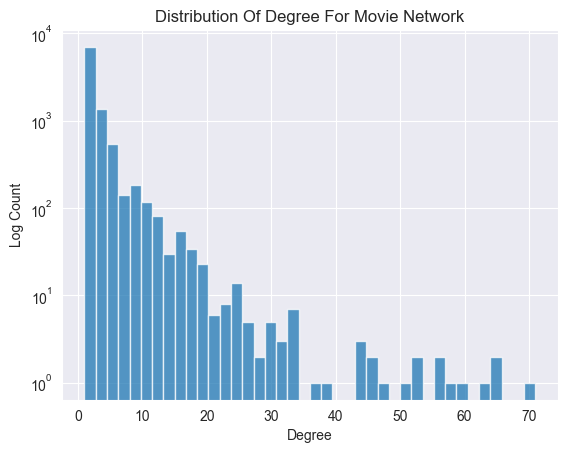

In [18]:
X = list(dict(G.degree).values())
plt.yscale("log")
plt.title("Distribution Of Degree For Movie Network")
plt.xlabel("Degree")
plt.ylabel("Log Count")
plt.hist(X, 40, alpha=0.75); 

### Community detection

In [19]:
def community_modularity(G, c, L):
    s = G.subgraph(c)
    L_c = s.number_of_edges()
    k_c = sum(dict(s.degree()).values())
    M_c = L_c / L - (k_c / (2 * L)) ** 2
    return M_c

def modularity(G, partitions):
    L = G.number_of_edges()
    return sum((community_modularity(G, c, L) for c in partitions))

In [20]:
def louvain_partitions(G):
    partition = community_louvain.best_partition(G, randomize=False, resolution=1)
    groups = defaultdict(set)
    for node, comm in partition.items():
        groups[comm].add(node)
    return list(groups.values())

In [21]:
communities = louvain_partitions(G)
len(communities)

1897

In [22]:
modularity(G, communities)

0.9375140549506528

Counter({2: 1303,
         3: 307,
         4: 107,
         5: 57,
         6: 33,
         7: 19,
         8: 9,
         9: 6,
         11: 5,
         24: 4,
         10: 4,
         17: 3,
         12: 3,
         151: 2,
         44: 2,
         20: 2,
         15: 2,
         23: 2,
         14: 2,
         126: 1,
         103: 1,
         43: 1,
         331: 1,
         18: 1,
         352: 1,
         183: 1,
         196: 1,
         25: 1,
         356: 1,
         175: 1,
         294: 1,
         113: 1,
         122: 1,
         68: 1,
         280: 1,
         568: 1,
         46: 1,
         64: 1,
         141: 1,
         128: 1,
         111: 1,
         92: 1,
         110: 1,
         36: 1})

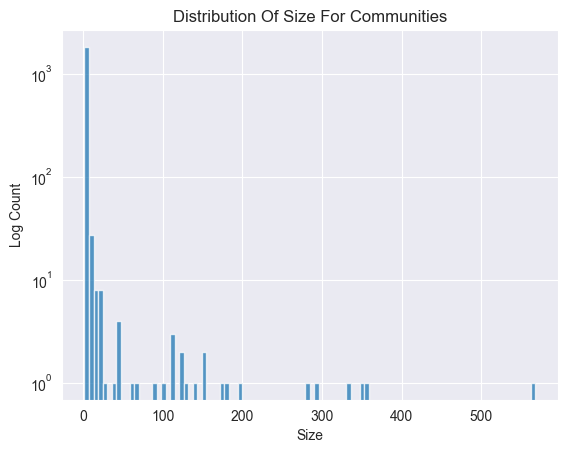

In [23]:
X = list(map(len, communities))
plt.yscale("log")
plt.title("Distribution Of Size For Communities")
plt.xlabel("Size")
plt.ylabel("Log Count")
plt.hist(X, 100, alpha=0.75);
Counter(X)

In [24]:
# Adding community labels to the df
movie_to_community = {
    movie_id: i
    for i, com in enumerate(communities)
    for movie_id in com
}

community_df = pl.DataFrame([
    {"asin": k, "community": v}
    for k, v in movie_to_community.items()
])

if "community" in filtered_df.columns:
    filtered_df = filtered_df.drop("community")

filtered_df = filtered_df.join(community_df, on="asin", how="left")
filtered_df.limit(2)

shape: (2, 9)
┌────────────┬────────────┬────────────┬───────────┬───┬───────────┬───────────┬───────┬───────────┐
│ asin       ┆ user_id    ┆ text       ┆ timestamp ┆ … ┆ title     ┆ average_r ┆ price ┆ community │
│ ---        ┆ ---        ┆ ---        ┆ ---       ┆   ┆ ---       ┆ ating     ┆ ---   ┆ ---       │
│ str        ┆ str        ┆ str        ┆ i64       ┆   ┆ str       ┆ ---       ┆ f64   ┆ i64       │
│            ┆            ┆            ┆           ┆   ┆           ┆ f64       ┆       ┆           │
╞════════════╪════════════╪════════════╪═══════════╪═══╪═══════════╪═══════════╪═══════╪═══════════╡
│ B0002J58ME ┆ AGXVBIUFLF ┆ This DVD   ┆ 114671349 ┆ … ┆ 10 Minute ┆ 4.6       ┆ 8.77  ┆ 361       │
│            ┆ GMVLATYXHJ ┆ was GREAT! ┆ 2000      ┆   ┆ Solution: ┆           ┆       ┆           │
│            ┆ YL4A5Q7Q   ┆ I am a st… ┆           ┆   ┆ Pilates   ┆           ┆       ┆           │
│ B000PIU2A0 ┆ AEFKF6R2GU ┆ this item  ┆ 155649642 ┆ … ┆ Battlespa ┆ 3.5       ┆ 19.99 ┆ null      │
│            ┆ SK2AWPSWRR ┆ was        ┆ 9981      ┆   ┆ ce        ┆           ┆       ┆           │
│            ┆ 4ZO36JVQ   ┆ canceled.  ┆           ┆   ┆           ┆           ┆       ┆           │
│            ┆            ┆ . . .n…    ┆           ┆   ┆           ┆           ┆       ┆           │
└────────────┴────────────┴────────────┴───────────┴───┴───────────┴───────────┴───────┴───────────┘

In [25]:
filtered_df = filtered_df.fill_null("")
attributes = ["title", "average_rating", "price", "community"]
df_attrs = filtered_df.select(["asin"] + attributes)
attr_dict = {row[0]: dict(zip(attributes, row[1:])) for row in df_attrs.rows()}
nx.set_node_attributes(G, attr_dict)
nx.write_gexf(G, "graph.gexf")

### Text analysis

In [26]:
all_asin = [asin for com in communities for asin in com]

In [27]:
filtered_df.filter(pl.col("community").is_null()).height

1226757

In [28]:
filtered_df = filtered_df.filter(pl.col("community").is_not_null()) # Filter reviews that is not part of community - Removed with weight threshold

In [29]:
sum(list(map(len, communities))), len(G.nodes)

(9590, 9590)

In [30]:
# size of each community
community_sizes = (
    filtered_df
    .group_by("community")
    .agg(pl.col("asin").n_unique().alias("community_size"))
    .sort("community_size", descending=True)
)

community_sizes.limit(10)

shape: (10, 2)
┌───────────┬────────────────┐
│ community ┆ community_size │
│ ---       ┆ ---            │
│ i64       ┆ u32            │
╞═══════════╪════════════════╡
│ 51        ┆ 568            │
│ 20        ┆ 356            │
│ 13        ┆ 352            │
│ 9         ┆ 331            │
│ 27        ┆ 294            │
│ 46        ┆ 280            │
│ 17        ┆ 196            │
│ 16        ┆ 183            │
│ 24        ┆ 175            │
│ 21        ┆ 151            │
└───────────┴────────────────┘

In [31]:
filtered_df.filter(pl.col("community") == 2).select("title").unique()

shape: (2, 1)
┌─────────────────────────────────┐
│ title                           │
│ ---                             │
│ str                             │
╞═════════════════════════════════╡
│ Vampire Knight: The Complete S… │
│ Vampire Knight Guilty: Complet… │
└─────────────────────────────────┘

### Tokens

In [32]:
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english')) # Include words like "movie", "like"

@lru_cache(maxsize=20000)
def cached_stem(word):
    return stemmer.stem(word)

def tokenize(tokens):
    return [cached_stem(t) for t in tokens if t not in stop_words]

def bigramify(tokens):
    return list(nltk_bigrams(tokens))

def process_tokens(tokens):
    return bigramify(tokenize(tokens))

In [43]:
filtered_df = filtered_df.with_columns(
    pl.col("text")
      .str.normalize("NFKC")
      .str.to_lowercase()
      .str.replace_all(r"\bblu[\s-]?ray\b", "bluray", literal=False)
      .str.replace_all(r"\bmovie\b|[^A-Za-z0-9 ]", "")
      .str.replace_all(r"\s+", " ", literal=False)
      .str.strip_chars()           
      .str.split(" ")  
      .map_elements(tokenize, return_dtype=pl.List(pl.Utf8))
      .alias("tokens")
)

In [56]:
filtered_df = filtered_df.with_columns(
    bigrams=pl.col("tokens").map_elements(bigramify, return_dtype=pl.List(pl.List(pl.Utf8)))
)
filtered_df.limit(5)

shape: (5, 11)
┌────────────┬────────────┬────────────┬───────────┬───┬───────┬───────────┬───────────┬───────────┐
│ asin       ┆ user_id    ┆ text       ┆ timestamp ┆ … ┆ price ┆ community ┆ tokens    ┆ bigrams   │
│ ---        ┆ ---        ┆ ---        ┆ ---       ┆   ┆ ---   ┆ ---       ┆ ---       ┆ ---       │
│ str        ┆ str        ┆ str        ┆ i64       ┆   ┆ f64   ┆ i64       ┆ list[str] ┆ list[list │
│            ┆            ┆            ┆           ┆   ┆       ┆           ┆           ┆ [str]]    │
╞════════════╪════════════╪════════════╪═══════════╪═══╪═══════╪═══════════╪═══════════╪═══════════╡
│ B0002J58ME ┆ AGXVBIUFLF ┆ This DVD   ┆ 114671349 ┆ … ┆ 8.77  ┆ 361       ┆ ["dvd",   ┆ [["dvd",  │
│            ┆ GMVLATYXHJ ┆ was GREAT! ┆ 2000      ┆   ┆       ┆           ┆ "great",  ┆ "great"], │
│            ┆ YL4A5Q7Q   ┆ I am a st… ┆           ┆   ┆       ┆           ┆ … "give"] ┆ ["great", │
│            ┆            ┆            ┆           ┆   ┆       ┆           ┆           ┆ "…        │
│ B001JNNDRY ┆ AEFKF6R2GU ┆ I grew up  ┆ 136408851 ┆ … ┆ 13.4  ┆ 16        ┆ ["grew",  ┆ [["grew", │
│            ┆ SK2AWPSWRR ┆ with this  ┆ 8000      ┆   ┆       ┆           ┆ "one", …  ┆ "one"],   │
│            ┆ 4ZO36JVQ   ┆ one.       ┆           ┆   ┆       ┆           ┆ "collect" ┆ ["one",   │
│            ┆            ┆ could…     ┆           ┆   ┆       ┆           ┆ ]         ┆ "cou…     │
│ B006OAXL92 ┆ AG35BKPUEU ┆ Wife and   ┆ 136183391 ┆ … ┆ -1.0  ┆ 51        ┆ ["wife",  ┆ [["wife", │
│            ┆ MX7LV5YLOQ ┆ daughter   ┆ 6000      ┆   ┆       ┆           ┆ "daughter ┆ "daughter │
│            ┆ 5YCQ3GOA   ┆ loved the  ┆           ┆   ┆       ┆           ┆ ", …      ┆ "],       │
│            ┆            ┆ st…        ┆           ┆   ┆       ┆           ┆ "movi"]   ┆ ["daugh…  │
│ B00JHH1ZN8 ┆ AHGAOIZVOD ┆ she        ┆ 155122242 ┆ … ┆ 6.99  ┆ 477       ┆ ["receiv" ┆ [["receiv │
│            ┆ NHYMNCBV4D ┆ received   ┆ 5031      ┆   ┆       ┆           ┆ , "yester ┆ ", "yeste │
│            ┆ ECZH42UQ   ┆ hers       ┆           ┆   ┆       ┆           ┆ day", …   ┆ rday"],   │
│            ┆            ┆ yesterday  ┆           ┆   ┆       ┆           ┆ "chi…     ┆ ["ye…     │
│            ┆            ┆ i …        ┆           ┆   ┆       ┆           ┆           ┆           │
│ B0B6NHYWP9 ┆ AFZUK3MTBI ┆ Subjective ┆ 166568668 ┆ … ┆ 7.99  ┆ 66        ┆ ["subject ┆ [["subjec │
│            ┆ BEDQOPAK3O ┆ movie      ┆ 7505      ┆   ┆       ┆           ┆ ",        ┆ t", "revi │
│            ┆ ATUOUKLA   ┆ review     ┆           ┆   ┆       ┆           ┆ "review", ┆ ew"],     │
│            ┆            ┆ here..…    ┆           ┆   ┆       ┆           ┆ … "opini… ┆ ["revi…   │
└────────────┴────────────┴────────────┴───────────┴───┴───────┴───────────┴───────────┴───────────┘

In [57]:
filtered_df.write_json("dataset/tokenizedReviews.json")
filtered_df.limit(5)

shape: (5, 11)
┌────────────┬────────────┬────────────┬───────────┬───┬───────┬───────────┬───────────┬───────────┐
│ asin       ┆ user_id    ┆ text       ┆ timestamp ┆ … ┆ price ┆ community ┆ tokens    ┆ bigrams   │
│ ---        ┆ ---        ┆ ---        ┆ ---       ┆   ┆ ---   ┆ ---       ┆ ---       ┆ ---       │
│ str        ┆ str        ┆ str        ┆ i64       ┆   ┆ f64   ┆ i64       ┆ list[str] ┆ list[list │
│            ┆            ┆            ┆           ┆   ┆       ┆           ┆           ┆ [str]]    │
╞════════════╪════════════╪════════════╪═══════════╪═══╪═══════╪═══════════╪═══════════╪═══════════╡
│ B0002J58ME ┆ AGXVBIUFLF ┆ This DVD   ┆ 114671349 ┆ … ┆ 8.77  ┆ 361       ┆ ["dvd",   ┆ [["dvd",  │
│            ┆ GMVLATYXHJ ┆ was GREAT! ┆ 2000      ┆   ┆       ┆           ┆ "great",  ┆ "great"], │
│            ┆ YL4A5Q7Q   ┆ I am a st… ┆           ┆   ┆       ┆           ┆ … "give"] ┆ ["great", │
│            ┆            ┆            ┆           ┆   ┆       ┆           ┆           ┆ "…        │
│ B001JNNDRY ┆ AEFKF6R2GU ┆ I grew up  ┆ 136408851 ┆ … ┆ 13.4  ┆ 16        ┆ ["grew",  ┆ [["grew", │
│            ┆ SK2AWPSWRR ┆ with this  ┆ 8000      ┆   ┆       ┆           ┆ "one", …  ┆ "one"],   │
│            ┆ 4ZO36JVQ   ┆ one.       ┆           ┆   ┆       ┆           ┆ "collect" ┆ ["one",   │
│            ┆            ┆ could…     ┆           ┆   ┆       ┆           ┆ ]         ┆ "cou…     │
│ B006OAXL92 ┆ AG35BKPUEU ┆ Wife and   ┆ 136183391 ┆ … ┆ -1.0  ┆ 51        ┆ ["wife",  ┆ [["wife", │
│            ┆ MX7LV5YLOQ ┆ daughter   ┆ 6000      ┆   ┆       ┆           ┆ "daughter ┆ "daughter │
│            ┆ 5YCQ3GOA   ┆ loved the  ┆           ┆   ┆       ┆           ┆ ", …      ┆ "],       │
│            ┆            ┆ st…        ┆           ┆   ┆       ┆           ┆ "movi"]   ┆ ["daugh…  │
│ B00JHH1ZN8 ┆ AHGAOIZVOD ┆ she        ┆ 155122242 ┆ … ┆ 6.99  ┆ 477       ┆ ["receiv" ┆ [["receiv │
│            ┆ NHYMNCBV4D ┆ received   ┆ 5031      ┆   ┆       ┆           ┆ , "yester ┆ ", "yeste │
│            ┆ ECZH42UQ   ┆ hers       ┆           ┆   ┆       ┆           ┆ day", …   ┆ rday"],   │
│            ┆            ┆ yesterday  ┆           ┆   ┆       ┆           ┆ "chi…     ┆ ["ye…     │
│            ┆            ┆ i …        ┆           ┆   ┆       ┆           ┆           ┆           │
│ B0B6NHYWP9 ┆ AFZUK3MTBI ┆ Subjective ┆ 166568668 ┆ … ┆ 7.99  ┆ 66        ┆ ["subject ┆ [["subjec │
│            ┆ BEDQOPAK3O ┆ movie      ┆ 7505      ┆   ┆       ┆           ┆ ",        ┆ t", "revi │
│            ┆ ATUOUKLA   ┆ review     ┆           ┆   ┆       ┆           ┆ "review", ┆ ew"],     │
│            ┆            ┆ here..…    ┆           ┆   ┆       ┆           ┆ … "opini… ┆ ["revi…   │
└────────────┴────────────┴────────────┴───────────┴───┴───────┴───────────┴───────────┴───────────┘

In [58]:
# filtered_df = pl.read_json("dataset/tokenizedReviews.json")

In [59]:
bigrams = (
    filtered_df
    .select(pl.col("bigrams"))
    .drop_nulls()
    .explode("bigrams")
    .get_column("bigrams")
    .to_list()
)

bigrams = [tuple(bg) for bg in bigrams if isinstance(bg, list) and len(bg) == 2]

filtered_df = filtered_df.drop("bigrams")

In [60]:
bigram_counts = Counter(bigrams)
first_counts = Counter()
second_counts = Counter()
for (w1, w2), cnt in bigram_counts.items():
    first_counts[w1] += cnt
    second_counts[w2] += cnt

N = len(bigrams)
items = list(bigram_counts.items())
bgs, nii = zip(*items)
w1s, w2s = zip(*bgs)

f = np.fromiter((first_counts[w] for w in w1s), float)
s = np.fromiter((second_counts[w] for w in w2s), float)
o = np.array(nii, float)

nio = f - o
noi = s - o
noo = N - (o + nio + noi)

Eii = f * s / N
Eio = f * (N - s) / N
Eoi = (N - f) * s / N
Eoo = (N - f) * (N - s) / N

chi2_vals = (o - Eii)**2/Eii + (nio - Eio)**2/Eio + (noi - Eoi)**2/Eoi + (noo - Eoo)**2/Eoo
p_vals = chi2.sf(chi2_vals, 1)

mask = (o > 50) & (p_vals < 0.001)
collocs = {bgs[i]: int(o[i]) for i in np.nonzero(mask)[0]}

In [61]:
tokenizer = MWETokenizer(list(collocs.keys()), separator="_")
filtered_df = filtered_df.with_columns(
    tokens=pl.col("tokens").map_elements(tokenizer.tokenize, return_dtype=pl.List(pl.Utf8))
)

In [62]:
filtered_df.limit(5)

shape: (5, 10)
┌────────────┬────────────┬────────────┬───────────┬───┬───────────┬───────┬───────────┬───────────┐
│ asin       ┆ user_id    ┆ text       ┆ timestamp ┆ … ┆ average_r ┆ price ┆ community ┆ tokens    │
│ ---        ┆ ---        ┆ ---        ┆ ---       ┆   ┆ ating     ┆ ---   ┆ ---       ┆ ---       │
│ str        ┆ str        ┆ str        ┆ i64       ┆   ┆ ---       ┆ f64   ┆ i64       ┆ list[str] │
│            ┆            ┆            ┆           ┆   ┆ f64       ┆       ┆           ┆           │
╞════════════╪════════════╪════════════╪═══════════╪═══╪═══════════╪═══════╪═══════════╪═══════════╡
│ B0002J58ME ┆ AGXVBIUFLF ┆ This DVD   ┆ 114671349 ┆ … ┆ 4.6       ┆ 8.77  ┆ 361       ┆ ["dvd_gre │
│            ┆ GMVLATYXHJ ┆ was GREAT! ┆ 2000      ┆   ┆           ┆       ┆           ┆ at", "sta │
│            ┆ YL4A5Q7Q   ┆ I am a st… ┆           ┆   ┆           ┆       ┆           ┆ y_home",  │
│            ┆            ┆            ┆           ┆   ┆           ┆       ┆           ┆ … "…      │
│ B001JNNDRY ┆ AEFKF6R2GU ┆ I grew up  ┆ 136408851 ┆ … ┆ 4.7       ┆ 13.4  ┆ 16        ┆ ["grew",  │
│            ┆ SK2AWPSWRR ┆ with this  ┆ 8000      ┆   ┆           ┆       ┆           ┆ "one", …  │
│            ┆ 4ZO36JVQ   ┆ one.       ┆           ┆   ┆           ┆       ┆           ┆ "collect" │
│            ┆            ┆ could…     ┆           ┆   ┆           ┆       ┆           ┆ ]         │
│ B006OAXL92 ┆ AG35BKPUEU ┆ Wife and   ┆ 136183391 ┆ … ┆ 4.7       ┆ -1.0  ┆ 51        ┆ ["wife_da │
│            ┆ MX7LV5YLOQ ┆ daughter   ┆ 6000      ┆   ┆           ┆       ┆           ┆ ughter",  │
│            ┆ 5YCQ3GOA   ┆ loved the  ┆           ┆   ┆           ┆       ┆           ┆ "love", … │
│            ┆            ┆ st…        ┆           ┆   ┆           ┆       ┆           ┆ "f…       │
│ B00JHH1ZN8 ┆ AHGAOIZVOD ┆ she        ┆ 155122242 ┆ … ┆ 4.9       ┆ 6.99  ┆ 477       ┆ ["receiv" │
│            ┆ NHYMNCBV4D ┆ received   ┆ 5031      ┆   ┆           ┆       ┆           ┆ , "yester │
│            ┆ ECZH42UQ   ┆ hers       ┆           ┆   ┆           ┆       ┆           ┆ day", …   │
│            ┆            ┆ yesterday  ┆           ┆   ┆           ┆       ┆           ┆ "chi…     │
│            ┆            ┆ i …        ┆           ┆   ┆           ┆       ┆           ┆           │
│ B0B6NHYWP9 ┆ AFZUK3MTBI ┆ Subjective ┆ 166568668 ┆ … ┆ 4.0       ┆ 7.99  ┆ 66        ┆ ["subject │
│            ┆ BEDQOPAK3O ┆ movie      ┆ 7505      ┆   ┆           ┆       ┆           ┆ ",        │
│            ┆ ATUOUKLA   ┆ review     ┆           ┆   ┆           ┆       ┆           ┆ "review", │
│            ┆            ┆ here..…    ┆           ┆   ┆           ┆       ┆           ┆ … "opini… │
└────────────┴────────────┴────────────┴───────────┴───┴───────────┴───────┴───────────┴───────────┘

In [63]:
community_docs = (
    filtered_df
    .group_by("community")
    .agg(
        pl.concat_list("tokens").flatten().alias("tokens"), 
        pl.len().alias("num_reviews")
    ).sort("num_reviews", descending=True)
)
top5com = community_docs.limit(20)
top5com

shape: (20, 3)
┌───────────┬─────────────────────────────────┬─────────────┐
│ community ┆ tokens                          ┆ num_reviews │
│ ---       ┆ ---                             ┆ ---         │
│ i64       ┆ list[str]                       ┆ u32         │
╞═══════════╪═════════════════════════════════╪═════════════╡
│ 51        ┆ ["wife_daughter", "love", … "b… ┆ 41682       │
│ 66        ┆ ["subject", "review", … "absor… ┆ 28513       │
│ 20        ┆ ["big", "chick_flick", … "irri… ┆ 21355       │
│ 46        ┆ ["super", "good_fun", … "best_… ┆ 20774       │
│ 17        ┆ ["matthew", "robbinss", … "min… ┆ 15789       │
│ …         ┆ …                               ┆ …           │
│ 30        ┆ ["lovingli", "watch_episod", …… ┆ 4203        │
│ 1         ┆ ["realli_love", "old_movi", … … ┆ 4074        │
│ 56        ┆ ["walk_away", "pound", … "stic… ┆ 3758        │
│ 42        ┆ ["great_cast", "gritti", … "up… ┆ 3710        │
│ 123       ┆ ["halfway", "stuck", … "love"]  ┆ 2635        │
└───────────┴─────────────────────────────────┴─────────────┘

In [64]:
def calculate_tf(tokens):
    total = len(tokens)
    counts = Counter(tokens)
    return {word: count / total for word, count in counts.items()}

def calculate_idf(docs: pl.DataFrame) -> dict[str, float]:
    N = docs.height
    df = (
        docs
        .explode("tokens")
        .unique(subset=["community", "tokens"])
        .group_by("tokens")
        .agg(pl.len().alias("df"))
        .with_columns((pl.lit(N) / pl.col("df")).log().alias("idf"))
        .sort("idf", descending=False)
    )
    return dict(zip(df["tokens"].to_list(), df["idf"].to_list()))

def calculate_tf_idf(tf, idf):
    tf_idf = {}
    for word, val in tf.items():
        tf_idf[word] = val * idf[word]
    return tf_idf

In [65]:
idf = calculate_idf(community_docs)

In [66]:
top_5_tf_idf = dict(zip(
    top5com["community"].to_list(),
    [calculate_tf_idf(calculate_tf(toks), idf) for toks in top5com["tokens"].to_list()]
))

### Word clouds

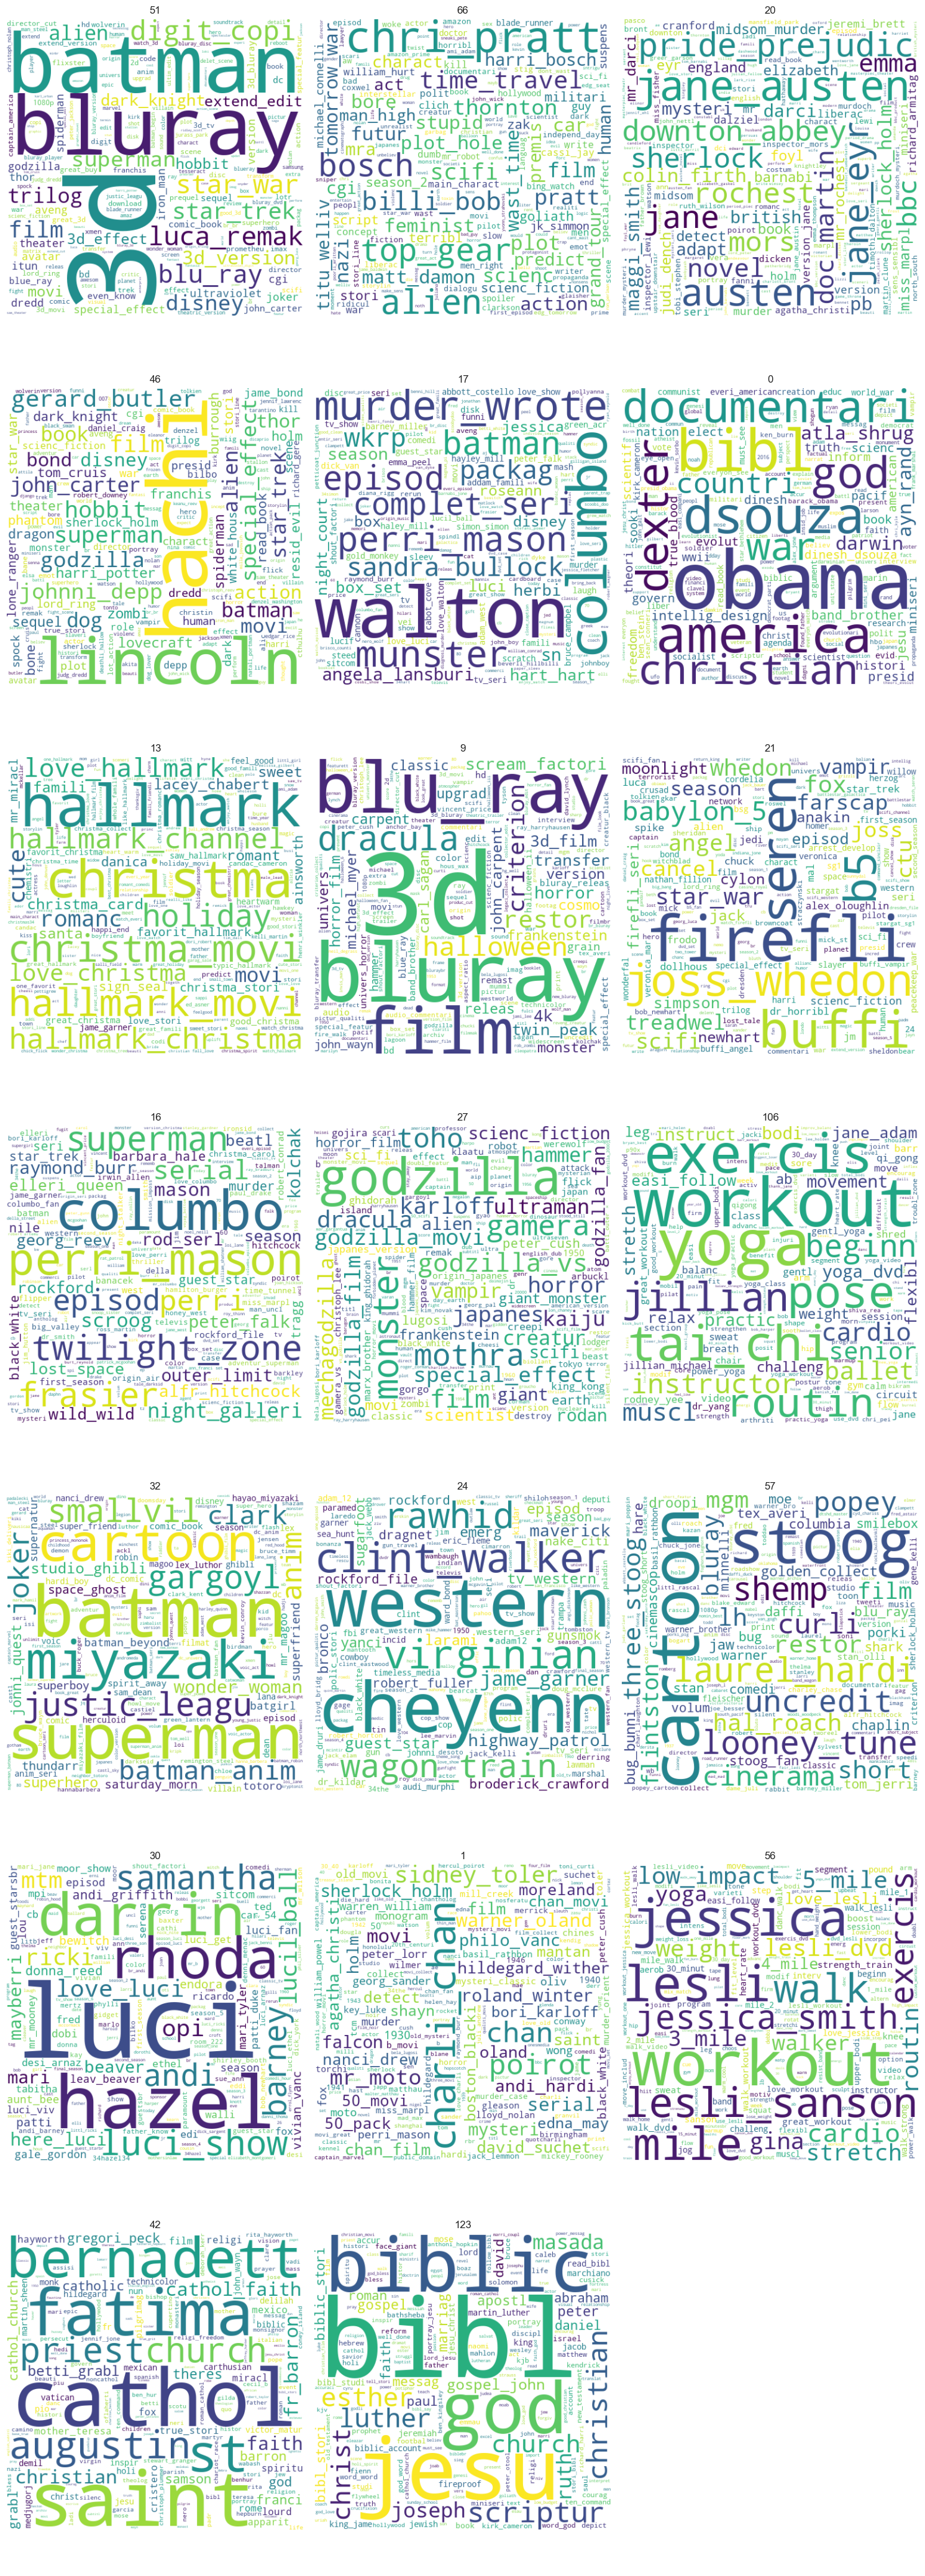

In [67]:
def plot_word_clouds_grid(word_freq, top_movies = None, ncols=3):
    communities = list(word_freq.keys())
    nrows = -(-len(communities) // ncols)
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 5, nrows * 6))
    axes = axes.flatten()

    for ax, comm in zip(axes, communities):
        cloud = WordCloud(background_color='white', height=500, width=500, colormap="viridis_r", contour_color='black', contour_width=0.5)
        cloud.generate_from_frequencies(word_freq[comm])
        movies = "\n".join(top_movies[comm]) if top_movies != None else str(comm)
        ax.imshow(cloud, interpolation='bilinear')
        ax.set_title(movies, fontsize=12)
        ax.axis('off')

    for ax in axes[len(communities):]:
        ax.axis('off')

    plt.tight_layout()
    plt.show()

plot_word_clouds_grid(top_5_tf_idf) # Plotting is based on tf-idf values and stemmed tokens